In [1]:
# This notebook implements a variational autoencoder that has only 2 dimensions in
# the code space, trains it on the MNIST data set then displays generated output
# images over this 2D latent space. 

# https://blog.keras.io/building-autoencoders-in-keras.html
# https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py

In [2]:
import collections
import datetime
import json
import math
import random
import time

import cv2
import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
import pylab
import scipy
import seaborn as sns
import skimage
import sklearn
import statsmodels as sm

np.random.seed(1337)

%matplotlib inline

sns.set(font_scale=1.3)
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

fsize=(20.0, 15.0)
linewidth = 1.0
dotsize = 15

Using TensorFlow backend.


### Build the variational autoencoder

In [3]:
original_dim = 784
intermediate_dim = 256
latent_dim = 2

In [4]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = keras.backend.random_normal(
                shape=(keras.backend.shape(z_mean)[0], latent_dim),
                mean=0.,
                stddev=1.0)
    return z_mean + keras.backend.exp(z_log_var / 2) * epsilon

In [5]:
# encoding the input image x
x_in = keras.layers.Input(shape=(original_dim,))
encoded = keras.layers.Dense(intermediate_dim, activation='relu')(x_in)
z_mean = keras.layers.Dense(latent_dim)(encoded)
z_log_var = keras.layers.Dense(latent_dim)(encoded)
z = keras.layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# building the encoder so we can reuse it
encoder = keras.Model(x_in, z_mean)

# decoding z back into x
z_decoder = keras.layers.Dense(intermediate_dim, activation='relu')
x_out_decoder = keras.layers.Dense(original_dim, activation='sigmoid')
z_decoded = z_decoder(z)
x_out = x_out_decoder(z_decoded)

# building the decoder separately so we can reuse it for generation
z_in = keras.layers.Input(shape=(latent_dim,))
decoder_z_decoded = z_decoder(z_in)
decoder_x_out = x_out_decoder(decoder_z_decoded)
decoder = keras.Model(z_in, decoder_x_out)

# building the variational autoencoder
vae = keras.Model(x_in, x_out)

In [6]:
def vae_loss(x_in, x_out):
    xent_loss = original_dim * keras.metrics.binary_crossentropy(x_in, x_out)
    kl_loss = - 0.5 * keras.backend.sum(
                    1 + z_log_var - keras.backend.square(z_mean) - keras.backend.exp(z_log_var), axis=-1)
    return keras.backend.mean(xent_loss + kl_loss)

In [7]:
vae.compile(loss=vae_loss, optimizer='rmsprop')
vae.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514      

### Prepare the data

In [8]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

### Training

In [9]:
n_epochs = 100

hist = vae.fit(
            x_train,
            x_train,
            epochs=n_epochs,
            callbacks=[keras.callbacks.EarlyStopping(
                                monitor='val_loss',
                                min_delta=0.005,
                                patience=10,
                                verbose=0,
                                mode='min')],
            batch_size=128,
            shuffle=True,
            validation_data=(x_test, x_test),
            verbose=0)

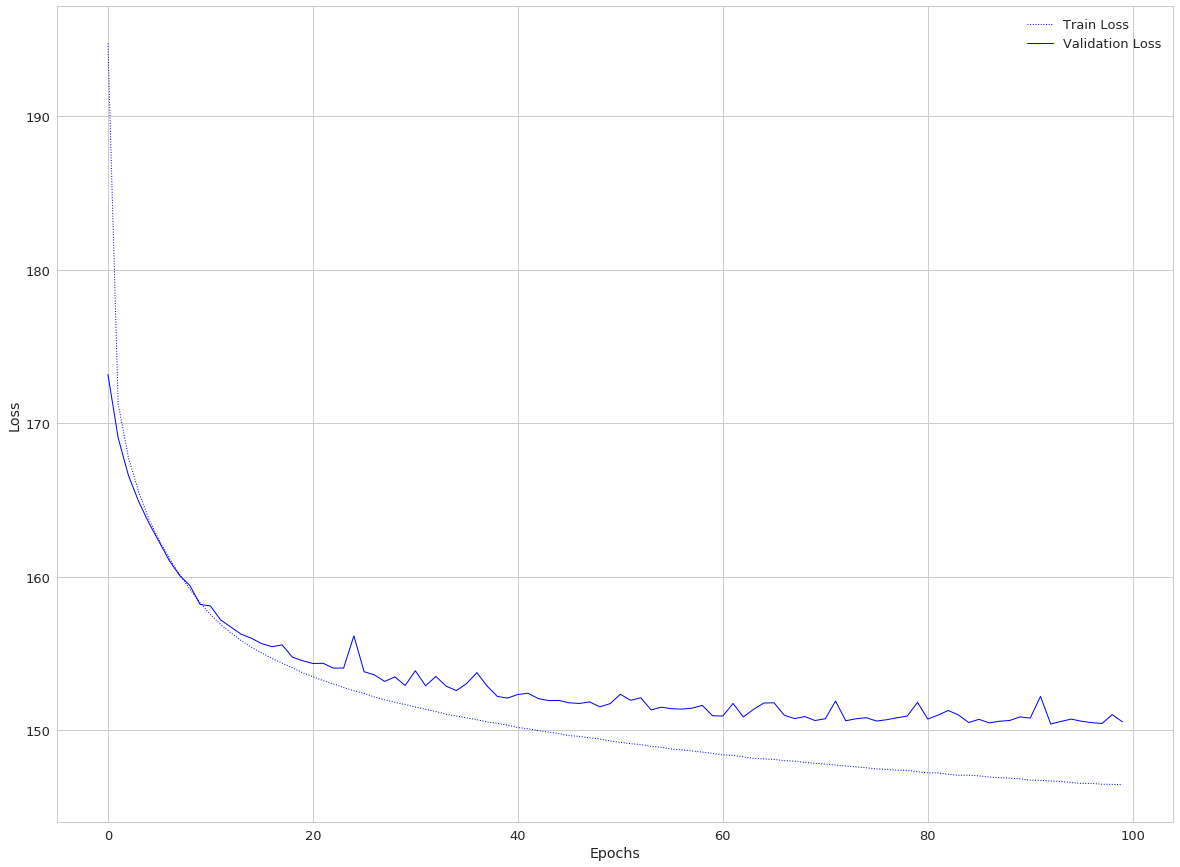

In [10]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

n_eps = range(len(loss))

_ = plt.figure(figsize=fsize)

_ = plt.plot(n_eps, loss, 'b:', label='Train Loss', linewidth=linewidth)
_ = plt.plot(n_eps, val_loss, 'b-', label='Validation Loss', linewidth=linewidth)

_ = plt.xlabel('Epochs')
_ = plt.ylabel('Loss')

_ = plt.legend()

### Visualize the results

In [11]:
encoded_imgs = encoder.predict(x_test, batch_size=128)
decoded_imgs = decoder.predict(encoded_imgs)

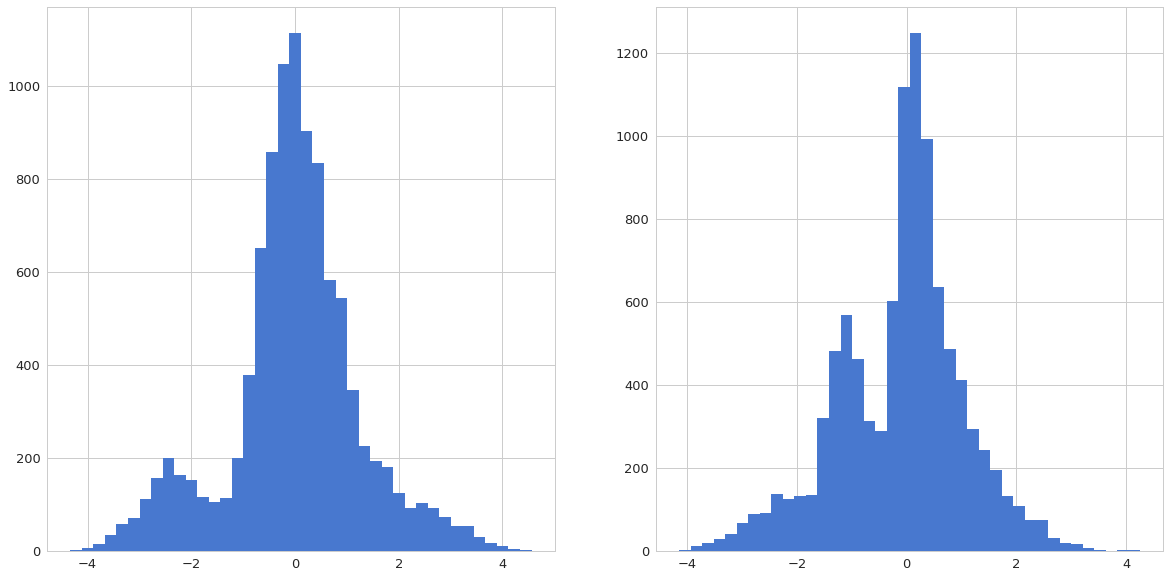

In [12]:
_ = plt.figure(figsize=(20, 10))

ax = plt.subplot(1, 2, 1)
_ = plt.hist(encoded_imgs[:, 0], bins=40)

ax = plt.subplot(1, 2, 2)
_ = plt.hist(encoded_imgs[:, 1], bins=40)

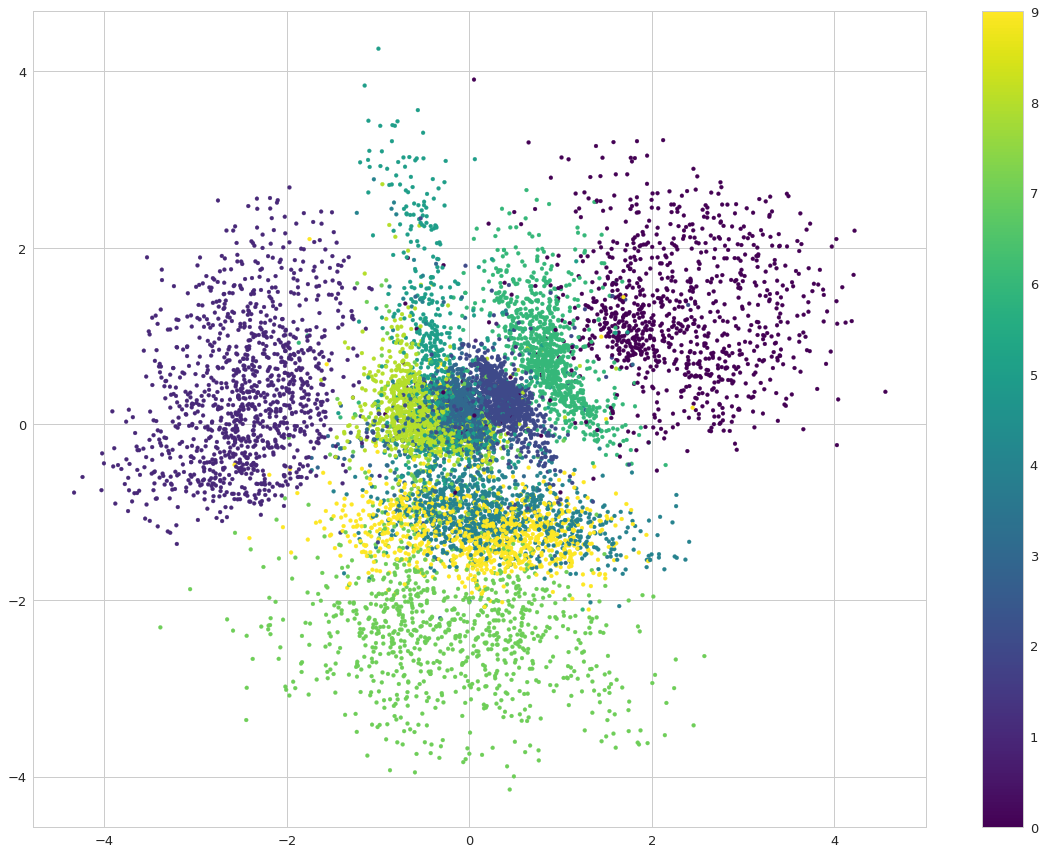

In [13]:
plt.figure(figsize=fsize)
_ = plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], s=dotsize, c=y_test, cmap='viridis')
_ = plt.colorbar()

In [14]:
def display_results(input_imgs, output_imgs, n_results, offset):
    _ = plt.figure(figsize=(20, int(40./n_results)))
    for i in range(n_results):
        ax = plt.subplot(2, n_results, i + 1)
        plt.imshow(input_imgs[offset + i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n_results, i + 1 + n_results)
        plt.imshow(output_imgs[offset + i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

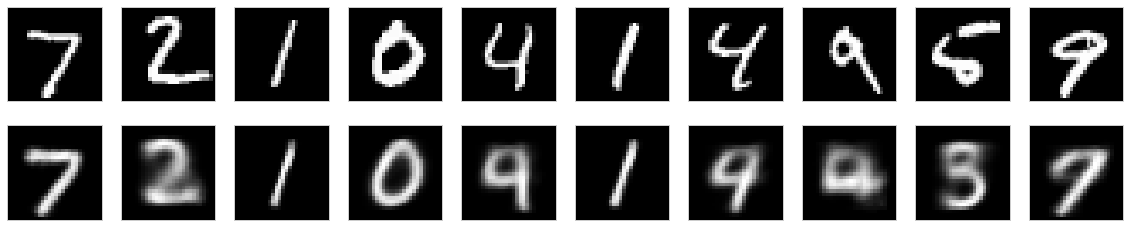

In [15]:
display_results(x_test, decoded_imgs, 10, 0)

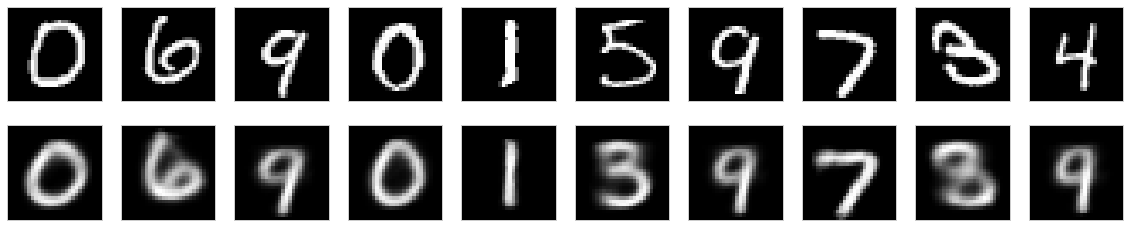

In [16]:
display_results(x_test, decoded_imgs, 10, 10)

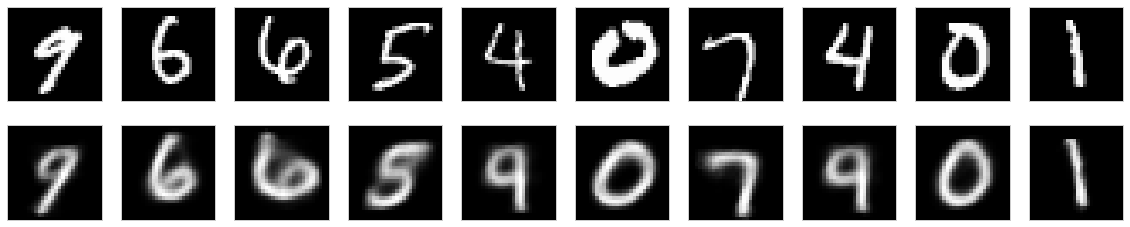

In [17]:
display_results(x_test, decoded_imgs, 10, 20)

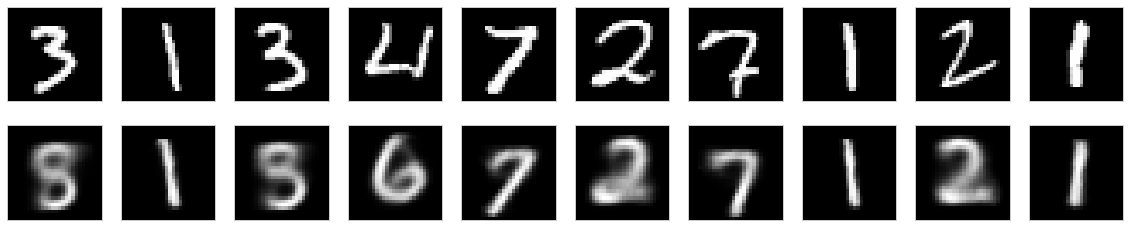

In [18]:
display_results(x_test, decoded_imgs, 10, 30)

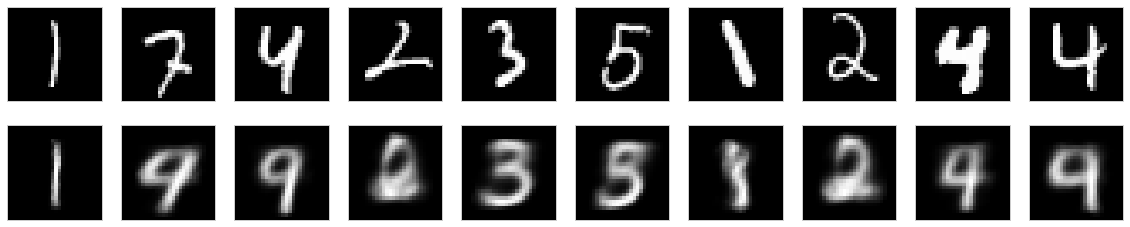

In [19]:
display_results(x_test, decoded_imgs, 10, 40)

### Generate output values on the 2D grid of latent variable space

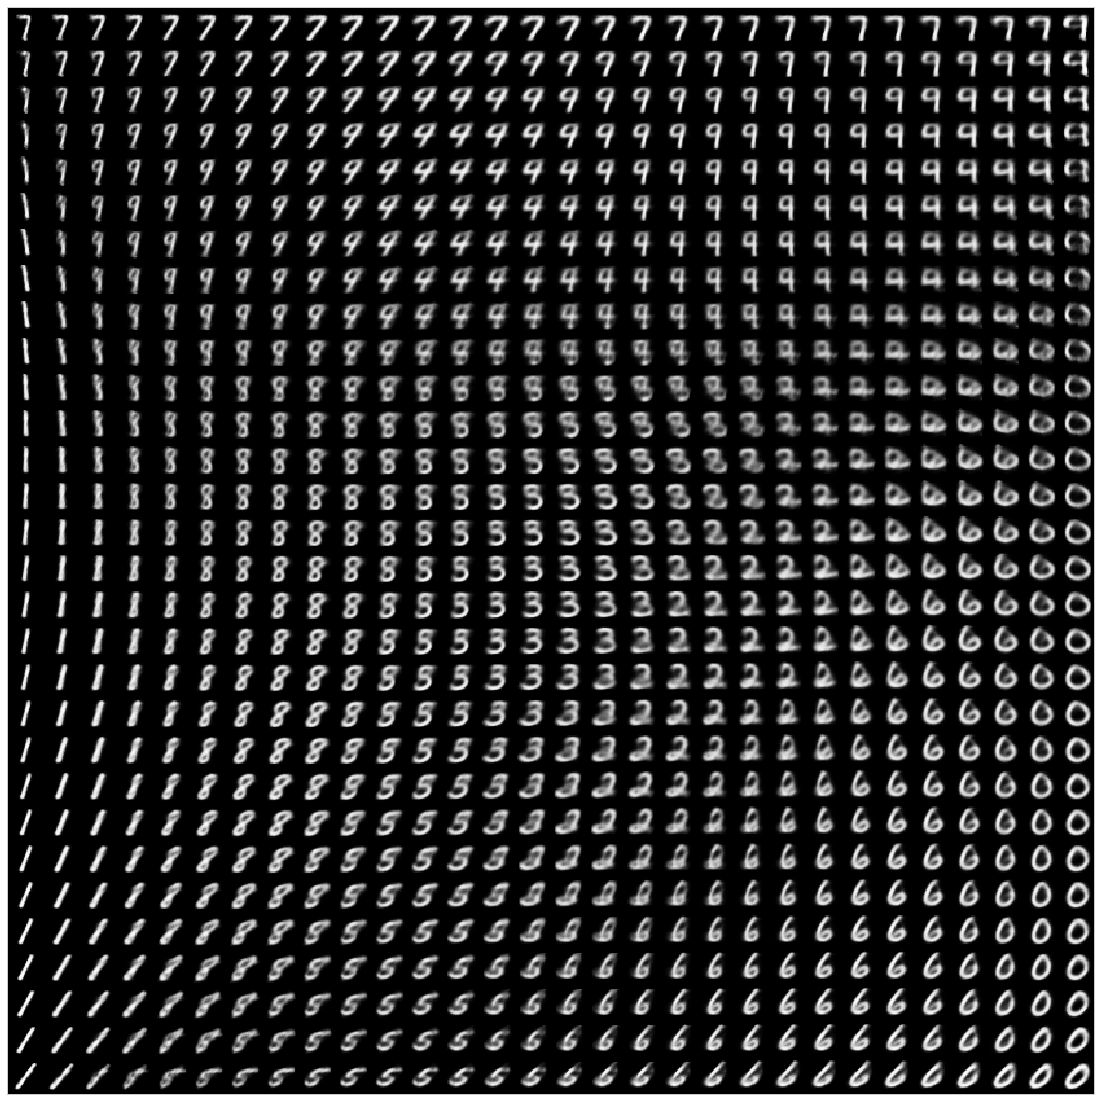

In [20]:
n = 30
digit_size = 28

figure = np.zeros((digit_size * n, digit_size * n))
grid_x = scipy.stats.norm.ppf(np.linspace(0.01, 0.99, n))
grid_y = scipy.stats.norm.ppf(np.linspace(0.01, 0.99, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(20, 20))
fig = plt.imshow(figure, cmap='Greys_r')
plt.grid(False)
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)